In [68]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('monokai')

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict 
import surprise
from surprise.reader import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise import SVD

np.random.seed(42) 

In [70]:
ratings_df = pd.read_csv('C:/Users/ngcph/Desktop/Recomendation_system/ml-latest-small/ratings.csv')
movies_df = pd.read_csv('C:/Users/ngcph/Desktop/Recomendation_system/ml-latest-small/movies.csv')

In [71]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [72]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [74]:
reader = Reader(rating_scale=(0.5, 5)) # The rating scale used for every rating. Default is (1, 5) but (0.5, 5)
data = Dataset.load_from_df(ratings_df[["userId", "movieId", "rating"]], reader=reader)  #Load a dataset from a pandas dataframe contain user, movie, rating, raeder: rating_scale needs to be specified             
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

In [75]:
def mae_vs_factors(algorithm, data):
      
    mae_algorithm = []
  
    for k in range(1, 101, 1):
        algo = algorithm(n_factors = k)
    
        #["test_mae"] is a numpy array with min accuracy value for each testset
        loss_fce = cross_validate(algo, data, measures=['MAE'], cv=5, verbose=False)["test_mae"].mean() 
        mae_algorithm.append(loss_fce)
        
    return mae_algorithm

In [76]:
mae_svd = mae_vs_factors(SVD,data)

In [77]:
def plot_mae(mae, algorithm):
 
    plt.figure(num=None, figsize=(11, 5), dpi=80, facecolor='w', edgecolor='k')

    plt.subplot(2,1,1)
    plt.plot(mae)
    plt.xlim(0,100)
    plt.title("{0} Performance: MAE Against Number of Factors".format(algorithm), size = 20 )
    plt.ylabel("Mean MAE (cv=5)")

    plt.subplot(2,1,2)
    plt.plot(mae)
    plt.xlim(0,50)
    plt.xticks(np.arange(0, 52, step=2))

    plt.xlabel("{0}(n_factor = k)".format(algorithm))
    plt.ylabel("Mean MAE (cv=5)")
    plt.axvline(np.argmin(mae), color = "r")

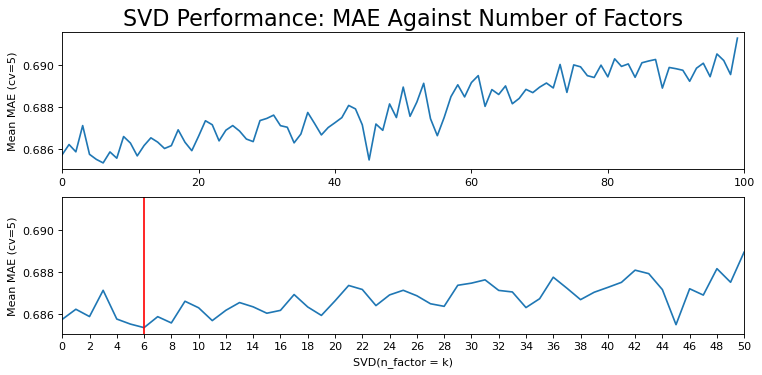

In [78]:
plot_mae(mae_svd,"SVD")

In [79]:
mae_svd_dict = {i: x for i, x in enumerate(mae_svd)}

In [80]:
b = []
for i in mae_svd_dict.values():
    b.append(i)

In [82]:
b.sort()

In [83]:
m=0
n=[]
for i in b:
    m=0
    for j in mae_svd_dict.values():
        if (i==j):
            n.append(m)
        m=m+1

In [84]:
n[0:10]

[6, 45, 5, 8, 11, 0, 4, 7, 2, 19]

In [85]:
param_grid = {'n_factors': n[0:10]}
gs = GridSearchCV(SVD, param_grid, measures=['mae'], cv=5)
gs.fit(data)


# best MAE score
print(gs.best_score['mae'])

# combination of parameters that gave the best MAE score
print(gs.best_params['mae'])

0.685563446657214
{'n_factors': 2}


In [86]:
for x in gs.best_params['mae'].values():
    print(x)

2


In [87]:
algo_SVD = SVD(n_factors = x)
algo_SVD.fit(trainset)


# Predict ratings for all pairs (i,j) that are NOT in the training set.
testset = trainset.build_anti_testset()

predictions = algo_SVD.test(testset)

# subset of the list  predictions
predictions[0:2]

[Prediction(uid=1, iid=10, r_ui=3.543608255669773, est=2.508131445610848, details={'was_impossible': False}),
 Prediction(uid=1, iid=17, r_ui=3.543608255669773, est=2.997950511993958, details={'was_impossible': False})]

In [88]:
def get_top_n(predictions, userId, movies_df, ratings_df, n = 10):
    '''Return the top N (default) movieId for a user,.i.e. userID and history for comparisom
    Args:
    Returns: 
  
    '''
    #Peart I.: Surprise docomuntation
    
    #1. First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    #2. Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[: n ]
    
    #Part II.: inspired by: https://beckernick.github.io/matrix-factorization-recommender/
    
    #3. Tells how many movies the user has already rated
    user_data = ratings_df[ratings_df.userId == (userId)]
    print('User {0} has already rated {1} movies.'.format(userId, user_data.shape[0]))

    
    #4. Data Frame with predictions. 
    preds_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_n.items() for pair in row],
                        columns=["userId" ,"movieId","rat_pred"])
    
    
    #5. Return pred_usr, i.e. top N recommended movies with (merged) titles and genres. 
    pred_usr = preds_df[preds_df["userId"] == (userId)].merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
            
    #6. Return hist_usr, i.e. top N historically rated movies with (merged) titles and genres for holistic evaluation
    hist_usr = ratings_df[ratings_df.userId == (userId) ].sort_values("rating", ascending = False).merge\
    (movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
    
    
    return hist_usr, pred_usr

In [89]:
hist_SVD_124, pred_SVD_124 = get_top_n(predictions, movies_df = movies_df, userId = 124, ratings_df = ratings_df)

User 124 has already rated 85 movies.


In [90]:
hist_SVD_124.head(15)

,userId,movieId,rating,timestamp,title,genres
0,124,2959,5.0,1147861149,Fight Club (1999),Action|Crime|Drama|Thriller
1,124,2571,5.0,1147861561,"Matrix, The (1999)",Action|Sci-Fi|Thriller
2,124,110,5.0,1147862138,Braveheart (1995),Action|Drama|War
3,124,4306,5.0,1147861207,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...
4,124,1270,5.0,1147862279,Back to the Future (1985),Adventure|Comedy|Sci-Fi
5,124,1240,5.0,1147862371,"Terminator, The (1984)",Action|Sci-Fi|Thriller
6,124,4993,5.0,1147861204,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
7,124,1214,5.0,1147862306,Alien (1979),Horror|Sci-Fi
8,124,527,5.0,1147861790,Schindler's List (1993),Drama|War
9,124,7153,5.0,1147861559,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy


In [91]:
pred_SVD_124

,userId,movieId,rat_pred,title,genres
0,124,858,4.333870,"Godfather, The (1972)",Crime|Drama
1,124,1221,4.296146,"Godfather: Part II, The (1974)",Crime|Drama
2,124,969,4.284974,"African Queen, The (1951)",Adventure|Comedy|Romance|War
3,124,926,4.269519,All About Eve (1950),Drama
4,124,3462,4.256387,Modern Times (1936),Comedy|Drama|Romance
5,124,7502,4.254545,Band of Brothers (2001),Action|Drama|War
6,124,2064,4.247868,Roger & Me (1989),Documentary
7,124,913,4.241865,"Maltese Falcon, The (1941)",Film-Noir|Mystery
8,124,6016,4.235348,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller
9,124,1228,4.233185,Raging Bull (1980),Drama
